# LightGBM Model

## Step 1: Import packages and set working directory

In [1]:
# Import packages
import optuna
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Optional Code: Here's a format for setting working directory, change as needed
import os
# os.chdir('/path/to/the/project')
os.chdir('/Users/zihanji/Desktop/DS340W')

## Step 2: Load the final cleaned data

In [3]:
data_final = pd.read_csv('./project/volume/data/processed/data_final.csv')

## Step 3: Building the LightGBM model

In [4]:
# Split the data to features and result
x = data_final.drop('SalePrice', axis = 1)
y = data_final['SalePrice']

In [5]:
# Split the data to train and test, with test size being 20% of the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [6]:
# Fit the model to built a prediction for x test
LightGBM = lgb.LGBMRegressor(force_col_wise = True, verbose = -1)
LightGBM.fit(x_train, y_train)
LightGBM_pred = LightGBM.predict(x_test)

## Step 4: Check for scores

In [7]:
# Check for the score of the prediction
LightGBM_score = LightGBM.score(x_train, y_train)
print('LightGBM Model Score: ', round(LightGBM_score, 3))

# R squared value
r2 = r2_score(y_test, LightGBM_pred)
print('R Squared: ', round(r2, 3))

# Adjusted R squared value
adj_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - x.shape[1] - 1)
print('Adjusted R Squared: ', round(adj_r2, 3))

# Mean squared error
mean_sq = mean_squared_error(y_test, LightGBM_pred)
print('Mean Squared Error: ', round(mean_sq, 3))

# Root mean squared error
root_mean_sq = np.sqrt(mean_sq)
print('Root Mean Squared Error: ', round(root_mean_sq, 3))

# Mean absolute error
mean_ab = mean_absolute_error(y_test, LightGBM_pred)
print('Mean Absolute Error: ', round(mean_ab, 3))

# Cross validation (or accuracy)
cv = cross_val_score(LightGBM, x, y, scoring = 'r2', cv = 5)
print('Accuracy: ', round(cv.mean() * 100, 3), '%')

LightGBM Model Score:  0.978
R Squared:  0.926
Adjusted R Squared:  0.919
Mean Squared Error:  0.014
Root Mean Squared Error:  0.117
Mean Absolute Error:  0.08
Accuracy:  90.237 %


## Step 5: Create visuals

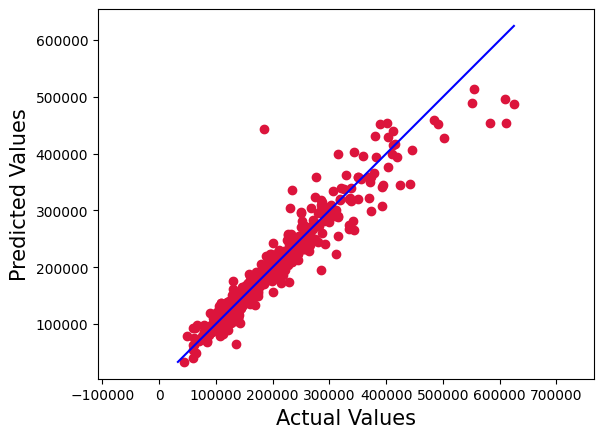

In [8]:
actual_price = np.expm1(y_test)
predicted_price = np.expm1(LightGBM_pred)

# Create a scatter plot
plt.scatter(actual_price, predicted_price, c = 'crimson')

# Draw the line of perfect prediction (where actual = predicted)
p1 = max(max(predicted_price), max(actual_price))
p2 = min(min(predicted_price), min(actual_price))
plt.plot([p1, p2], [p1, p2], 'b-')

# Add labels
plt.xlabel('Actual Values', fontsize = 15)
plt.ylabel('Predicted Values', fontsize = 15)

# Make sure the axes are scaled equally
plt.axis('equal')

plt.show()

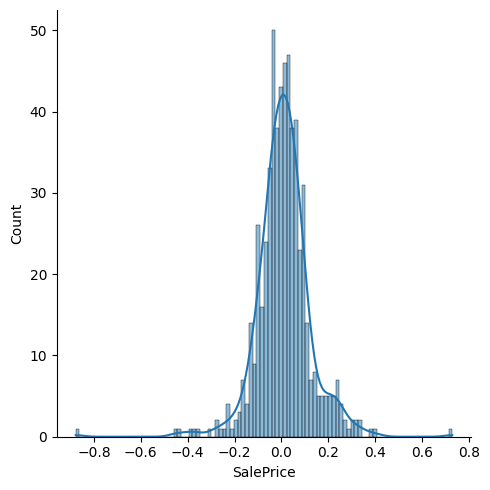

In [9]:
# Distribution of residuals (difference between actual and predicted value)
sb.displot((y_test - LightGBM_pred), bins = 100, kde = True)

## Step 6: Hyperparameter tuning (optuna)

In [10]:
def objective(trial):
    # Define hyperparameter search space
    parameters = {'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log = True),
                  'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
                  'subsample': trial.suggest_float('subsample', 0.05, 1.0),
                  'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
                  'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100)}
    # Train LightGBM model
    model = lgb.LGBMRegressor(**parameters)
    model.fit(x_train, y_train, eval_set=[(x_test, y_test)])
    # Evaluate model
    predict = model.predict(x_test)
    mse = mean_squared_error(y_test, predict)
    rmse = np.sqrt(mse)
    return rmse

In [11]:
# Hide Optuna's info logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run optuna optimization
study = optuna.create_study(direction = 'minimize')  # Minimize RMSE
study.optimize(objective, n_trials = 50)

# Print best hyperparameters
print('Best RMSE: ', study.best_value)
print('Best Hyperparameters: ', study.best_params)

Best RMSE:  0.10949298800486641
Best Hyperparameters:  {'learning_rate': 0.06356308269160839, 'num_leaves': 247, 'subsample': 0.8089198362525021, 'colsample_bytree': 0.6059131479315829, 'min_data_in_leaf': 40}


In [12]:
# Built a LightGBM model with the new hyperparameter option
# {'learning_rate': 0.06356308269160839, 'num_leaves': 247, 'subsample': 0.8089198362525021, 
# 'colsample_bytree': 0.6059131479315829, 'min_data_in_leaf': 40}
LightGBM_mod = lgb.LGBMRegressor(learning_rate = 0.06356308269160839, num_leaves = 247, 
                                 subsample = 0.8089198362525021, colsample_bytree = 0.6059131479315829, 
                                 min_data_in_leaf = 40, verbose = -1)
LightGBM_mod.fit(x_train, y_train)
LightGBM_pred = LightGBM_mod.predict(x_test)

## Step 7: Check for scores

In [13]:
# Check for the score of the prediction
LightGBM_mod_score = LightGBM_mod.score(x_train, y_train)
print('LightGBM Model Score: ', round(LightGBM_mod_score, 3))

# R squared value
r2 = r2_score(y_test, LightGBM_pred)
print('R Squared: ', round(r2, 3))

# Adjusted R squared value
adj_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - x.shape[1] - 1)
print('Adjusted R Squared: ', round(adj_r2, 3))

# Mean squared error
mean_sq = mean_squared_error(y_test, LightGBM_pred)
print('Mean Squared Error: ', round(mean_sq, 3))

# Root mean squared error
root_mean_sq = np.sqrt(mean_sq)
print('Root Mean Squared Error: ', round(root_mean_sq, 3))

# Mean absolute error
mean_ab = mean_absolute_error(y_test, LightGBM_pred)
print('Mean Absolute Error: ', round(mean_ab, 3))

# Cross validation (or accuracy)
cv = cross_val_score(LightGBM_mod, x, y, scoring = 'r2', cv = 5)
print('Accuracy: ', round(cv.mean() * 100, 3), '%')

LightGBM Model Score:  0.957
R Squared:  0.935
Adjusted R Squared:  0.929
Mean Squared Error:  0.012
Root Mean Squared Error:  0.109
Mean Absolute Error:  0.074
Accuracy:  90.707 %


## Step 8: Create visuals

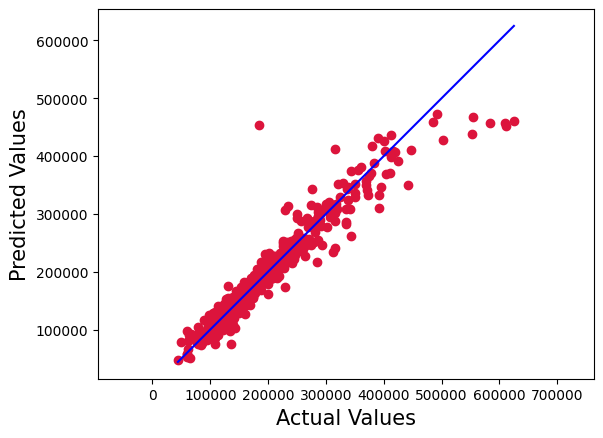

In [14]:
actual_price = np.expm1(y_test)
predicted_price = np.expm1(LightGBM_pred)

# Create a scatter plot
plt.scatter(actual_price, predicted_price, c = 'crimson')

# Draw the line of perfect prediction (where actual = predicted)
p1 = max(max(predicted_price), max(actual_price))
p2 = min(min(predicted_price), min(actual_price))
plt.plot([p1, p2], [p1, p2], 'b-')

# Add labels
plt.xlabel('Actual Values', fontsize = 15)
plt.ylabel('Predicted Values', fontsize = 15)

# Make sure the axes are scaled equally
plt.axis('equal')

plt.show()

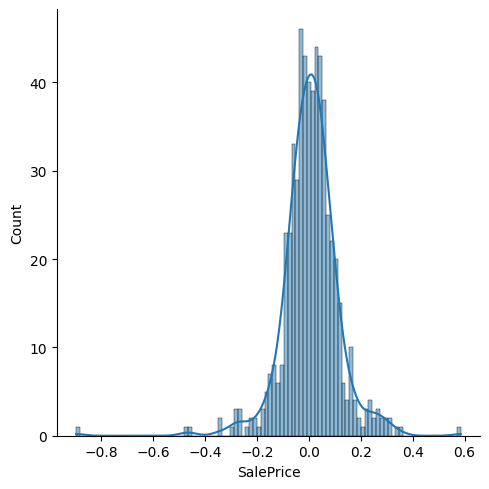

In [15]:
# Distribution of residuals (difference between actual and predicted value)
sb.displot((y_test - LightGBM_pred), bins = 100, kde = True)

## Step 9: Check feature importance

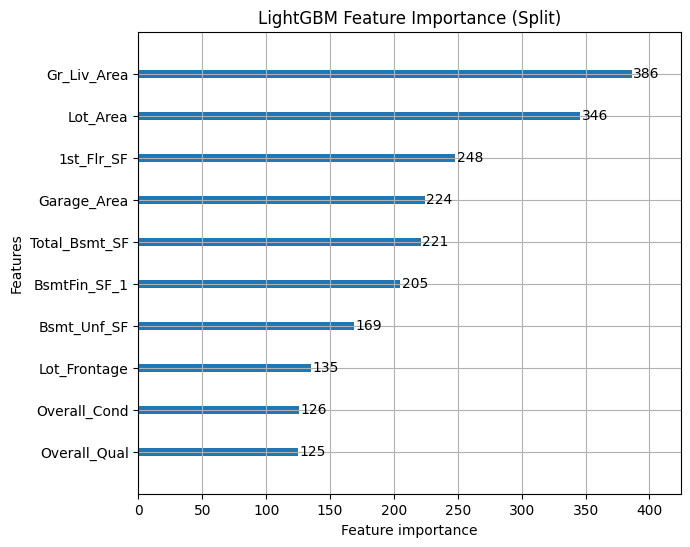

In [16]:
lgb.plot_importance(LightGBM_mod, importance_type = 'split', figsize = (7, 6), 
                    title = 'LightGBM Feature Importance (Split)', max_num_features = 10)
plt.show()